# Prerequisites

- Create python virtual environment -> `python -m venv venv`
- Activate the virtual environment -> `. ./venv/scripts/activate`
- Install python requirements in terminal -> `pip install -r requirements.txt`
- Kaggle API key (can be obtained from https://www.kaggle.com). Follow the following instructions: https://github.com/Kaggle/kaggle-api


# Imports


In [2]:
from collections import Counter
import kaggle as kg
import zipfile as zf
import dask.dataframe as df
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, udf, row_number

import ast
import json


C:\Users\Mathieu\AppData\Local\Temp\ipykernel_7340\1808412364.py:4: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use a new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

To disable this warning in the future, set dask config:

    # via Python
    >>> dask.config.set({'dataframe.query-planning-warning': False})

    # via CLI
    dask 

# Download the dataset


In [3]:
# Make sure you have the Kaggle API installed 
kg.api.authenticate()

# Download the movies dataset
kg.api.dataset_download_files('rounakbanik/the-movies-dataset')

# Unzip the dataset
zf.ZipFile('the-movies-dataset.zip').extractall('data')

# Remove the zip file
os.remove('the-movies-dataset.zip')

# Read the data

Set the follwing CSVs as dataframes:

- Movies Dataset: adult, belongs_to_collection, budget, genres, homepage, id, imdb_id, original_language, original_title, overview, popularity, poster_path, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status, tagline, title, video, vote_average, vote_count

- Ratings Dataset: userId, movieId, rating, timestamp

- Links Dataset: movieId, imdbId, tmdbId

- Keywords Dataset: id, keywords


In [4]:
# Load the dataset into a Dask dataframe
movies_df = df.read_csv('data/movies_metadata.csv', delimiter=',', header=0, dtype=str)
ratings_df = df.read_csv('data/ratings.csv', delimiter=',', header=0, dtype=str)
links_df = df.read_csv('data/links.csv', delimiter=',', header=0, dtype=str)
keywords_df = df.read_csv('data/keywords.csv', delimiter=',', header=0, dtype=str)


# Print the first 5 rows of each dataframe
print(movies_df.head(5))
print(ratings_df.head(5))
print(links_df.head(5))
print(keywords_df.head(5))

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                               <NA>  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                               <NA>  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                  <NA>   8844  tt0113497         

# Data Preprocessing

This code segment preprocesses movie, ratings, links, and keywords datasets by selecting relevant columns, handling missing values and data types, and then displays the first five rows of each for verification.


In [5]:
# Preprocessing the Movies Dataset
movies_df = movies_df[['id', 'original_title', 'genres', 'release_date', 'vote_average', 'vote_count']]
movies_df = movies_df.dropna(subset=['original_title', 'genres'])
movies_df['release_date'] = df.to_datetime(movies_df['release_date'], errors='coerce')

# Preprocessing the Ratings Dataset
ratings_df = ratings_df[['userId', 'movieId', 'rating', 'timestamp']]

# Convert data types in Pandas/Dask (if required)
ratings_df['userId'] = ratings_df['userId'].astype(int)
ratings_df['movieId'] = ratings_df['movieId'].astype(int)
ratings_df['rating'] = ratings_df['rating'].astype(float)

# Preprocessing the Links Dataset
links_df = links_df[['movieId', 'imdbId', 'tmdbId']]

# Preprocessing the Keywords Dataset
keywords_df = keywords_df[['id', 'keywords']]

# Print the updated first 5 rows of each dataframe
print(movies_df.head(5))
print(ratings_df.head(5))
print(links_df.head(5))
print(keywords_df.head(5))

      id               original_title  \
0    862                    Toy Story   
1   8844                      Jumanji   
2  15602             Grumpier Old Men   
3  31357            Waiting to Exhale   
4  11862  Father of the Bride Part II   

                                              genres release_date  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   1995-10-30   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   1995-12-15   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   1995-12-22   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   1995-12-22   
4                     [{'id': 35, 'name': 'Comedy'}]   1995-02-10   

  vote_average vote_count  
0          7.7       5415  
1          6.9       2413  
2          6.5         92  
3          6.1         34  
4          5.7        173  
   userId  movieId  rating   timestamp
0       1      110     1.0  1425941529
1       1      147     4.5  1425942435
2       1      858     5.0  1425941523
3       1     

# Exploratory Data Analysis (EDA)

This code segment visualizes the distribution of movie ratings, the most common movie genres, the distribution of movie release years, and the relationship between average vote and vote count using various plots.


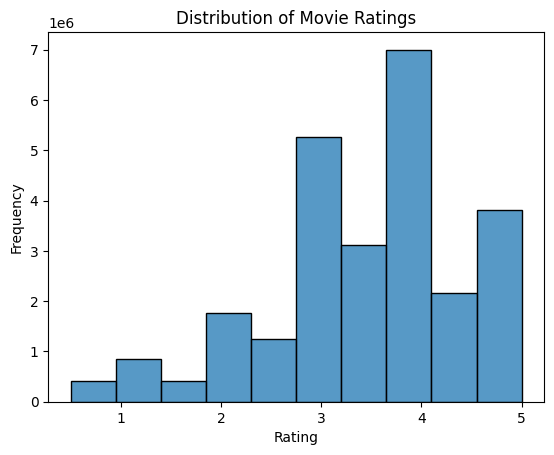

'    182212
r     69131
a     61860
e     55830
m     53132
      51913
o     48578
,     48082
]     45466
[     45466
i     39713
n     35716
y     28531
c     28015
t     26241
D     24197
l     18026
C     17492
d     16686
A     12029
F      9756
u      9034
s      8829
T      8395
h      7625
R      6737
H      6072
M      4834
v      4263
S      3053
W      2365
g      1623
V       770
P         5
w         2
G         2
p         2
O         2
k         2
E         1
x         1
B         1
b         1
dtype: int64


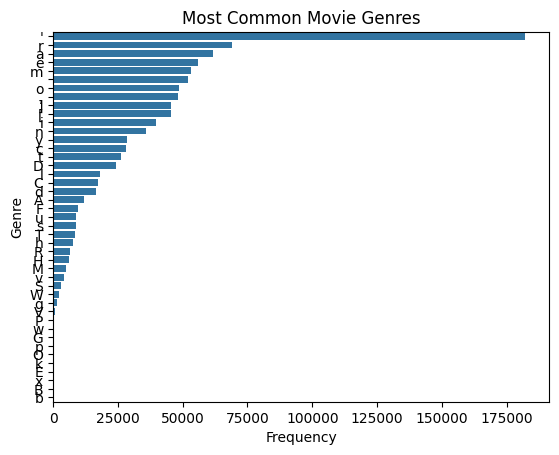

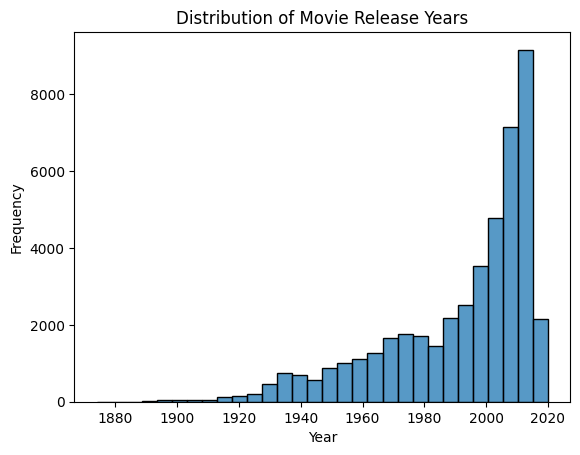

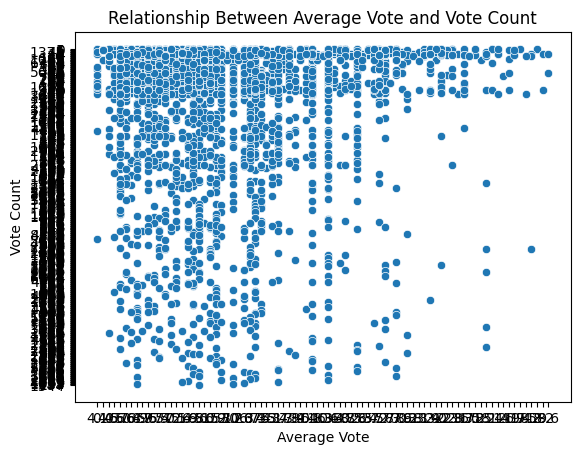

In [8]:
# Distribution of Movie Ratings
ratings_series = ratings_df['rating'].compute()
sns.histplot(ratings_series, kde=False, bins=10)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Most Common Genres
def extract_genres(genre_str):
    try:
        genres = json.loads(genre_str.replace("'", "\""))
        return [genre['name'] for genre in genres]
    except json.JSONDecodeError:
        return []

# Apply function and count genres
genre_series = movies_df['genres'].apply(extract_genres, meta=('genres', 'object')).compute()
genre_counts = Counter(g for genres in genre_series for g in genres.replace("'", "").replace("[", "").replace("]", "").replace(" ", "").split(","))

# Most common genres
common_genres = pd.Series(genre_counts).sort_values(ascending=False)

sns.barplot(x=common_genres.values, y=common_genres.index)
plt.title('Most Common Movie Genres')
plt.xlabel('Frequency')
plt.ylabel('Genre')
plt.show()

# Release Year Distribution
movies_df['year'] = movies_df['release_date'].dt.year
year_series = movies_df['year'].compute()
sns.histplot(year_series.dropna(), kde=False, bins=30)
plt.title('Distribution of Movie Release Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

# Relationship Between Rating and Vote Count
sample_movies_df = movies_df.sample(frac=0.1).compute()
sns.scatterplot(data=sample_movies_df, x='vote_average', y='vote_count')
plt.title('Relationship Between Average Vote and Vote Count')
plt.xlabel('Average Vote')
plt.ylabel('Vote Count')
plt.show()

In [16]:
print(genre_series.head(5))

for i in genre_series:
    for j in i.replace("'", "").replace("[", "").replace("]", "").replace(" ", "").split(","):
        print(j)

#print(genre_seriess.head(5))

#genre_countss = Counter(g for genres in genre_series for g in genres)
#common_genress = pd.Series(genre_counts).sort_values(ascending=False)

#print(common_genress.head(5))

0     ['Animation', 'Comedy', 'Family']
1    ['Adventure', 'Fantasy', 'Family']
2                 ['Romance', 'Comedy']
3        ['Comedy', 'Drama', 'Romance']
4                            ['Comedy']
Name: genres, dtype: string
Animation
Comedy
Family
Adventure
Fantasy
Family
Romance
Comedy
Comedy
Drama
Romance
Comedy
Action
Crime
Drama
Thriller
Comedy
Romance
Action
Adventure
Drama
Family
Action
Adventure
Thriller
Adventure
Action
Thriller
Comedy
Drama
Romance
Comedy
Horror
Family
Animation
Adventure
History
Drama
Action
Adventure
Drama
Crime
Drama
Romance
Crime
Comedy
Crime
Comedy
Adventure
Action
Comedy
Crime
Comedy
Thriller
Crime
Drama
Thriller
Action
Adventure
Crime
Thriller
Drama
Fantasy
ScienceFiction
Thriller
Drama
Romance
Drama
Comedy
Drama
Family
Drama
Romance
Fantasy
ScienceFiction
Adventure
Drama
Crime
Drama
Crime
ScienceFiction
Thriller
Mystery
Romance
Adventure
Fantasy
Drama
Comedy
Family
History
Drama
Romance
Drama
Adventure
History
Drama
Family
Comedy
Family
Romance
Com

# Building Collaborative Filtering Model using ALS (Matrix Factorization)

This code sets up a collaborative filtering recommendation system using Spark's ALS algorithm. It initializes a Spark session and converts the ratings data into a Spark DataFrame. Then, it defines a grid of hyperparameters for the ALS model and performs cross-validation to find the best combination of hyperparameters. Finally, it trains the ALS model using the best parameters.


In [11]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Movie Recommendation System") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

print("Spark session started")

schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True),
])

# Convert the Pandas DataFrame to a Spark DataFrame
ratings_spark_df = spark.createDataFrame(ratings_df.compute(), schema=schema)

print("Spark DataFrame created")

# ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

print("Model initialized")

# Define a grid of hyperparameters to test
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [5,10]) \
    .addGrid(als.maxIter, [5,10]) \
    .addGrid(als.regParam, [0.05,0.1]) \
    .build()

# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

print("Hyperparameters defined")

# Cross-validation setup
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

print("Cross-validation has been setup")

# Fit ALS model to training data
cvModel = crossval.fit(ratings_spark_df)

# Extract the best model
bestModel = cvModel.bestModel

print("ALS model trained")


Spark session started
Spark DataFrame created
Model initialized
Hyperparameters defined
Cross-validation has been setup


# Building Content-Based Filtering Model using TF-IDF

This code initializes a Spark session, converts Dask DataFrames (movies_df and keywords_df) into Spark DataFrames, and merges them based on a common key (id). It then tokenizes the genres and keywords columns and applies TF-IDF to convert them into numerical features.


In [ ]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Movie Recommendation System") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

# Convert the 'movies_df' and 'keywords_df' to Spark DataFrames
movies_spark_df = spark.createDataFrame(movies_df.compute())
keywords_spark_df = spark.createDataFrame(keywords_df.compute())

# Merge genres and keywords
movies_spark_df = movies_spark_df.join(keywords_spark_df, movies_spark_df.id == keywords_spark_df.id).select(movies_spark_df["*"], keywords_spark_df["keywords"])

# Tokenize genres and keywords
tokenizer = Tokenizer(inputCol="genres", outputCol="tokenized_genres")
movies_spark_df = tokenizer.transform(movies_spark_df)

tokenizer = Tokenizer(inputCol="keywords", outputCol="tokenized_keywords")
movies_spark_df = tokenizer.transform(movies_spark_df)

# TF-IDF
hashingTF = HashingTF(inputCol="tokenized_genres", outputCol="rawFeatures")
featurizedData = hashingTF.transform(movies_spark_df)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

# Model Evaluation


In [ ]:
# Evaluate the collaborative filtering model
predictions = bestModel.transform(ratings_spark_df)
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

#Evaluate the content-based model
# TODO



Root-mean-square error = 0.7377794869500348


# Comparison and Analysis


In [ ]:
# Compare the performance of both models
# Analyze the strengths and weaknesses


# Visualization and Reporting


In [ ]:
# Visualization code
# Summarize findings, insights, and conclusions